# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
import random
from dateutil.relativedelta import relativedelta
import os

In [2]:
from my_functions import merge_basic, scaler, inversed_scale, consolidation_prediction, plot_prediction
from my_functions import preparing_to_predict, plot_metrics

In [3]:
from especial_functions import balance_items_test, get_full_lags, feature_silver, integration_new_features_map
from especial_functions import features_rows_train_silver, get_maps_from, balance_items_test
from especial_functions import augmentation_reduction

In [4]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [5]:
#from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans

In [6]:
import warnings
warnings.filterwarnings('ignore')

### Data

In [7]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [8]:
def exploiting_words(data):
    items_vector = list(data.item_name.unique())
    items_vector = pd.DataFrame({'item_name': items_vector})
    items_vector['lenstr'] = items_vector.item_name.str.len() ## this can be a feature
    items_vector['NWords'] = items_vector.item_name.str.split().str.len()
    items_vector['ItemWord0'] = items_vector.item_name.str.split().str.get(0)
    items_vector['ItemWord_1'] = items_vector.item_name.str.split().str.get(-1)
    
    def my_tokengen(data, columnx):
        unique_words = list()
        for string in  list(data[columnx].values):
            for word in string.split():
                unique_words.append(word)
        unique_words = set(unique_words)
        unique_words = list(unique_words)
        unique_words.sort()
        number = [idx[0] +1 for idx in enumerate(unique_words)]
        map_word = {x:y for x,y in zip(unique_words, number)}

        data[columnx] = data[columnx].map(map_word)
        return data
    
    items_vector = my_tokengen(items_vector, 'ItemWord0')
    items_vector = my_tokengen(items_vector, 'ItemWord_1')
    items_vector = items_vector.merge(data[['item_name','item_id']], on = 'item_name', how = 'left').drop(columns = 'item_name')
    
    return {'item_name_explo':items_vector}

In [9]:
def cleaning_shop_categs(shops, categories):
    shops[['shop_comp1','shop_comp2']] = shops.shop_name.str.split(' "',expand=True,)
    shops['shop_comp1'] = shops.shop_comp1.replace({r'\([^)]*\)' : ''}, regex=True)
    shops['shop_comp1'] = shops['shop_comp1'].str.split(' ').str[0]

    shops['shop_comp2'] = shops.shop_comp2.replace({r'\([^)]*\)' : ''}, regex=True)
    shops['shop_comp2'] = shops.shop_comp2.replace({'"' :''}, regex=True)

    categories[['categ_comp1','categ_comp2']] = categories.item_category_name.str.split(" - ",expand=True,)
    categories['categ_comp1'] = categories.categ_comp1.replace({r'\([^)]*\)' : ''}, regex=True)
    categories['categ_comp2'] = categories.categ_comp2.replace({r'\([^)]*\)' : ''}, regex=True)
    
    return shops, categories

def indexing_shop_categs(data, column):
    my_map = dict()
    for index, value in enumerate(data[column].unique()):
        my_map[value] = index
    data[f'map_{column}'] = data[column].map(my_map)
    return data

<b> Treating the map item, category and shop

In [10]:
items_feature =  exploiting_words(data = items)

In [11]:
shops_feature, categories_feature = cleaning_shop_categs(shops, categories)
shops_feature = indexing_shop_categs(shops_feature, 'shop_comp1')
shops_feature = indexing_shop_categs(shops_feature, 'shop_comp2')
categories_feature = indexing_shop_categs(categories_feature, 'categ_comp1')
categories_feature = indexing_shop_categs(categories_feature, 'categ_comp2')

<b> Fast Cleaning

In [12]:
median = daily_train[(daily_train.shop_id == 32) & (daily_train.item_id == 2973) & (daily_train.date_block_num == 4) & (daily_train.item_price > 0)].item_price.median()
daily_train.loc[daily_train.item_price < 0, 'item_price'] = median

In [13]:
daily_train.loc[daily_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
daily_train.loc[daily_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
daily_train.loc[daily_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [14]:
### test preparation
test_data = test
test_data['date'] = pd.to_datetime(datetime.datetime(2015, 11, 1))
test_data['date_block_num'] = 35
test_data['item_price'] =  np.nan
test_data['item_cnt_day'] = np.nan
test_data = test_data[daily_train.columns]

In [15]:
test_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2015-11-01,35,5,5037,NaN,NaN
1,2015-11-01,35,5,5320,NaN,NaN
2,2015-11-01,35,5,5233,NaN,NaN
3,2015-11-01,35,5,5232,NaN,NaN
4,2015-11-01,35,5,5268,NaN,NaN


In [16]:
daily_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


<b> preparing Train aggregation

In [17]:
def convert_bronze(data, train = False, test_order = 34):
    if train:
        data['date'] = pd.to_datetime(data['date'], format = '%d.%m.%Y')
        
    data['SaleDateMY'] = data['date'].dt.to_period('M').dt.to_timestamp()
    data['item_cnt_day'] = data['item_cnt_day'].clip(0,20)
    
    data = data.groupby(['SaleDateMY', 'date_block_num', 'shop_id', 'item_id'],
                                ).agg( Sale = ('item_cnt_day', 'sum'),
                                   item_price = ('item_price', 'mean'))
    data = data.reset_index().rename(columns = {'SaleDateMY':'Date'})
    
    data['min_date'] = data.groupby(['shop_id', 'item_id'])['Date'].transform('min')

    ### completing with 0 items with 0 in no dates
    
    map_aggg = data[['Date','item_id','shop_id','min_date','Sale']]\
        .pivot_table(index = ['item_id','shop_id','min_date'], columns = ['Date'], values = 'Sale', aggfunc = 'count').reset_index()
    map_aggg = map_aggg.melt(id_vars=['item_id','shop_id','min_date'], value_vars = map_aggg.columns[2:],  var_name='Date', value_name='Nothing')
    map_aggg = map_aggg[map_aggg.Date >= map_aggg.min_date]
    map_aggg = map_aggg[['item_id','shop_id','Date']]
    
    group_data = map_aggg.merge(data, on = ['item_id','shop_id','Date'], how = 'left').fillna(0)
    group_data['Sale'] = group_data['Sale'].clip(0,20)
    
    del map_aggg
    
    if train:
        ### get a map of the dates
        date_list =[group_data.Date.min()]
        date = group_data.Date.min()
        max_date = group_data.Date.max()
        while date <= max_date:
            date = date_list[-1] + relativedelta(months=1)
            date_list.append(date)
        order_list = range(1,len(date_list)+1)
        date_map = pd.DataFrame({'Date':date_list, 'Order':order_list})
        group_data = group_data.merge(date_map, on = 'Date', how = 'left')
    group_data = group_data.drop(columns = ['date_block_num', 'min_date'])
    return group_data

In [18]:
def merge_basic(train_data, items, items_feature ,categories, shops):
    train_merge = train_data.merge(items, on = 'item_id', how = 'left')
    train_merge = train_merge.merge(items_feature, on = 'item_id', how = 'left')
    train_merge = train_merge.merge(categories, on = 'item_category_id', how = 'left')
    train_merge = train_merge.merge(shops, on = 'shop_id', how = 'left')

    return train_merge

In [19]:
daily_train.shape

(2935849, 6)

In [20]:
train_bronze = convert_bronze(data = daily_train, train = True)

In [21]:
train_bronze.shape

(9784152, 6)

In [22]:
train_merge = merge_basic(train_data = train_bronze, items = items, items_feature = items_feature['item_name_explo'],
                            categories = categories_feature, shops = shops_feature)

In [23]:
train_merge.shape

(9784152, 22)

<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

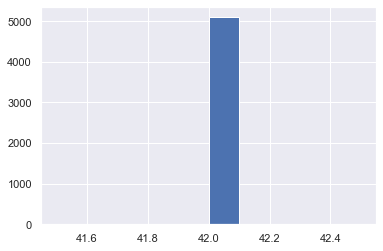

In [24]:
test_data.groupby(['item_id']).agg(lit = ('shop_id','nunique')).reset_index().lit.hist()

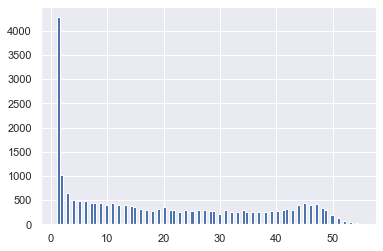

In [25]:
daily_train.groupby(['item_id']).agg(lit = ('shop_id','nunique')).reset_index().lit.hist(bins = 100)

In [26]:
#len(daily_train.item_id.unique()),len(test_data.item_id.unique()), len(test_data.merge(daily_train, on = ['item_id'], how ='inner').item_id.unique())

In [27]:
#len(daily_train.groupby(['shop_id','item_id']).agg(lit = ('item_cnt_day','max')).reset_index()) ,len(test_data),  len(test_data.merge(daily_train, on = ['item_id','shop_id'], how ='inner').item_id.unique())

<b> validation must be some data with historique and some very new data

In [28]:
def supagg(data):
    data['lit'] = data.groupby(['item_id'])['shop_id'].transform('nunique')
    agge = data.groupby(['item_id','shop_id']).agg(lit = ('lit','max')).reset_index()
    return agge

In [29]:
agg_daily_train = supagg(daily_train)

In [30]:
def  reduce_sample(data, frac, single = False ):
    if single:
        data = data.groupby(['item_id','shop_id']).agg(lit = ('lit','max')).reset_index().sample(frac = frac, random_state = 123)
    else:
        data = data.sample(frac = frac, random_state = 123)
        data = data[['item_id','shop_id','lit']]
    return data

In [31]:
vector_drop_1 = reduce_sample(data = agg_daily_train[agg_daily_train.lit > 10], frac = 0.60)
vector_drop_2 = reduce_sample(data = agg_daily_train[agg_daily_train.lit <= 1], frac = 0.60, single = True)

In [32]:
itemshop_to_drop_1 = list(vector_drop_1.assign(shopitem = vector_drop_1.shop_id.astype('str') + '_' + vector_drop_1.item_id.astype('str'))\
                        .shopitem.unique())
itemshop_to_drop_2 = list(vector_drop_2.assign(shopitem = vector_drop_2.shop_id.astype('str') + '_' + vector_drop_2.item_id.astype('str'))\
                        .shopitem.unique())

items_to_drop_all = itemshop_to_drop_1 + itemshop_to_drop_2

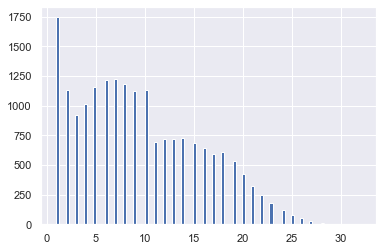

In [33]:
daily_train = daily_train.assign(shopitem = daily_train.shop_id.astype('str') + '_' + daily_train.item_id.astype('str'))

daily_train[ ~daily_train.shopitem.isin(items_to_drop_all) ]\
    .groupby(['item_id']).agg(lit = ('shop_id','nunique')).reset_index().lit.hist(bins = 100)

In [34]:
train_bronze.Date.max()

Timestamp('2015-10-01 00:00:00')

In [35]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

#### hold-out Train

 almost 95% of the items available

In [36]:
date_val = datetime.datetime(2014, 10, 1)

In [37]:
train_merge = train_merge.assign(shopitem = train_merge.shop_id.astype('str') + '_' + train_merge.item_id.astype('str'))

In [38]:
def get_val_window(data, date, items_to_drop_all):
    val_window_1 = data[data.Date == date ]
    already_found = val_window_1.shopitem.unique()
    
    val_window_2 = data[ (data.Date != date) & (data.shopitem.isin(items_to_drop_all)) ]
    val_window_2['Order'] = val_window_2.groupby(['shop_id','item_id']).cumcount() + 1
    val_window_2 = val_window_2[val_window_2.Order == 1]
    val_window_2['Date'] = date
    val_window_2 = val_window_2[~val_window_2.shopitem.isin(already_found)]
    val_window_2['Sale'] = 0
    print(len(val_window_1),len(val_window_2))
    val_window = pd.concat([val_window_1,val_window_2])
    return val_window

In [39]:
train_full = train_merge[(train_merge.Date < date_val) & (~train_merge.shopitem.isin(items_to_drop_all))]  # itemshop_to_drop_2
val_window = get_val_window(data = train_merge, date = date_val, items_to_drop_all = items_to_drop_all)

339005 44222


In [40]:
train_full.columns

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'ItemWord0',
       'ItemWord_1', 'item_category_name', 'categ_comp1', 'categ_comp2',
       'map_categ_comp1', 'map_categ_comp2', 'shop_name', 'shop_comp1',
       'shop_comp2', 'map_shop_comp1', 'map_shop_comp2', 'shopitem'],
      dtype='object')

In [41]:
train_full.Date.max(), train_full.Date.min()

(Timestamp('2014-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [42]:
train_full.shape, val_window.shape

((2098106, 23), (383227, 23))

### Exploration of the features

In [64]:
def get_full_lags_for_KNN(whole, date_to_take):
    
    data = whole[ whole.Date < date_to_take]
    data['itemShopMax'] = data.groupby(['shop_id','item_id']).SaleBin.transform('max')
    data['possnumb'] = np.where(data.SaleBin > 0 , 1,0)
    data['possCounts'] = data.groupby(['item_id','shop_id']).possnumb.transform('sum')
    
    features_dictionary = dict()
    #########################################
    ### only item Columns  ##################
    ########################################

    date_max = data.Date.max()
    date_max = datetime.datetime(date_max.year, date_max.month, date_max.day)
    
    data['OrderGot'] = data.groupby(['item_id']).Order.transform('min')
    data['SpaceOrder'] = data['Order'] - data['OrderGot']
    
    #########################################
    ### starts  ##################
    ########################################

    starts = data.groupby('item_id').agg(OrderGot = ('OrderGot','max')).reset_index()
    
    features_dictionary['Starts'] = {'data':starts, 'keys':['item_id']}
    
    
    ####################### ####
    ####### counting ##########
    ############################
    
    def counting_go(data,variable, column, variable_name, time_feature = 'Date'):
        data_to_use = data
        data_to_use = data_to_use[data_to_use.SaleBin >= 1]
        df_feature = data_to_use.groupby([variable] + [time_feature]).agg(countx = (column,'nunique')).reset_index()
        df_feature = df_feature.rename(columns = {'countx': f'count_unique_{variable_name}'})
        if time_feature == 'Date':
            df_feature[time_feature] = df_feature[time_feature] + pd.DateOffset(months=1)
        else:
            df_feature[time_feature] = df_feature[time_feature] + 1
        del data_to_use
        return  {'data': df_feature, 'keys':[variable,  time_feature]}
        
    features_dictionary['count shop in item'] = counting_go(data = data,variable = 'shop_id', column = 'item_id', variable_name = 'item')
    features_dictionary['count shop in item'] = counting_go(data = data,variable = 'shop_id', column = 'item_category_id', variable_name = 'categ')
    features_dictionary['count shop in categ1'] = counting_go(data = data,variable = 'shop_id', column = 'map_categ_comp1', variable_name = 'categ1')
    features_dictionary['count shop in categ1'] = counting_go(data = data,variable = 'map_shop_comp2', column = 'map_categ_comp1', variable_name = 'categ1')
    features_dictionary['count shop in categ2'] = counting_go(data = data,variable = 'shop_id', column = 'map_categ_comp2', variable_name = 'categ2')
    features_dictionary['count item in shop'] = counting_go(data = data,variable = 'item_id', column = 'shop_id', variable_name = 'shop_id')
    
    def counting_total(data, variables,  variable_name, rolling):
        data_to_use = data
        data_to_use = data_to_use[data_to_use.SaleBin >= 1]
        maxDate = data_to_use.Date.max()
        #beginDate = maxDate - relativedelta(months = 12)
        #data_to_use = data_to_use[data_to_use.Date > beginDate]
        df_feature = data_to_use.groupby(variables + ['Date']).agg(countx = ('SaleBin','sum')).reset_index()
        df_feature['rolling_feature'] = df_feature.sort_values('Date').groupby(variables)['countx'].rolling(rolling, min_periods=1).sum().reset_index(level=0, drop=True)
        df_feature['Date'] = df_feature['Date'] + pd.DateOffset(months=1)
        df_feature = df_feature.rename(columns = { 'rolling_feature': f'fullcount_{variable_name}'}).drop(columns = ['countx'])
            
        return  {'data': df_feature, 'keys':variables + ['Date']}
    
    features_dictionary['count catego global'] = counting_total(data = data, variables = ['map_categ_comp1'],  variable_name = 'categcomp', rolling = 3)
    features_dictionary['count itemword global'] = counting_total(data = data, variables = ['ItemWord0'],  variable_name = 'itemword0', rolling = 3)

    return features_dictionary

def integration_new_features_map(data, dict_feature, filter_ceros = True):
    data_wow = data

    ## first merge
    data_wow = data_wow.merge(dict_feature['Starts']['data'], on = dict_feature['Starts']['keys'], how = 'left')
    
    ### further features
    data_wow['SpaceOrder'] = data_wow['Order'] - data_wow['OrderGot']
    data_wow['SpaceOrder'] = data_wow['SpaceOrder'].fillna(0)

    ## second merge
    
    for keyx in list(dict_feature.keys())[1:]:
        data_left = dict_feature[keyx]['data']
        onx = dict_feature[keyx]['keys']
        data_wow = data_wow.merge(data_left, on = onx, how = 'left')

        
    return data_wow.fillna(0)

In [43]:
train_go = train_full.assign(SaleBin = np.where(train_full.Sale > 0 ,1 , 0))
train_go = train_go[['item_id','shop_id','item_category_id','map_categ_comp1','map_categ_comp2','map_shop_comp1','map_shop_comp2',
                     'ItemWord0','ItemWord_1',
                     'Order','Date', 'SaleBin']]

In [66]:
features_dictionary = get_full_lags_for_KNN(whole = train_go, date_to_take = date_val) ## for train but result easy in val
full_features_dictionary = {**features_dictionary}

In [67]:
train_feature = integration_new_features_map(data = train_go, dict_feature = full_features_dictionary)

In [68]:
train_feature.shape

(2098106, 20)

In [83]:
train_feature.groupby('SaleBin')['Date'].count()

SaleBin
0    1638905
1     459201
Name: Date, dtype: int64

In [81]:
train_feature.head()

,item_id,shop_id,item_category_id,map_categ_comp1,map_categ_comp2,map_shop_comp1,map_shop_comp2,ItemWord0,ItemWord_1,Order,Date,SaleBin,OrderGot,SpaceOrder,count_unique_categ,count_unique_categ1,count_unique_categ2,count_unique_shop_id,fullcount_categcomp,fullcount_itemword0
0,19,25,40,11,22,14,18,19,5166,1,2013-01-01,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0
1,27,58,19,5,2,30,42,27,4918,1,2013-01-01,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0
2,28,31,30,8,14,14,24,27,4918,1,2013-01-01,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0
3,28,46,30,8,14,22,36,27,4918,1,2013-01-01,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0
4,29,31,23,5,6,14,24,27,4918,1,2013-01-01,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0


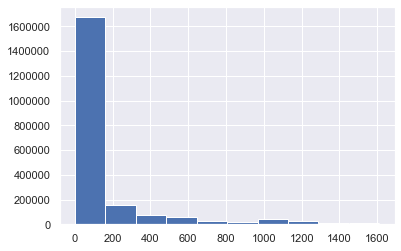

In [72]:
train_feature.fullcount_itemword0.hist()

In [73]:
tf = train_feature.sample(frac = 0.1)

In [69]:
train_feature.columns

Index(['item_id', 'shop_id', 'item_category_id', 'map_categ_comp1',
       'map_categ_comp2', 'map_shop_comp1', 'map_shop_comp2', 'ItemWord0',
       'ItemWord_1', 'Order', 'Date', 'SaleBin', 'OrderGot', 'SpaceOrder',
       'count_unique_categ', 'count_unique_categ1', 'count_unique_categ2',
       'count_unique_shop_id', 'fullcount_categcomp', 'fullcount_itemword0'],
      dtype='object')

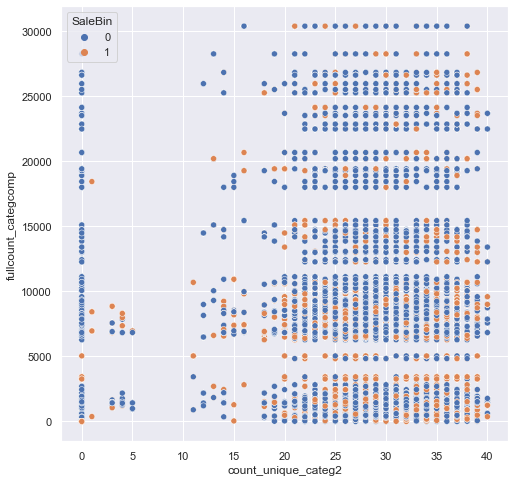

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

sns.scatterplot(ax = axs , data=tf, x='count_unique_categ2', y = 'fullcount_categcomp', hue = 'SaleBin')

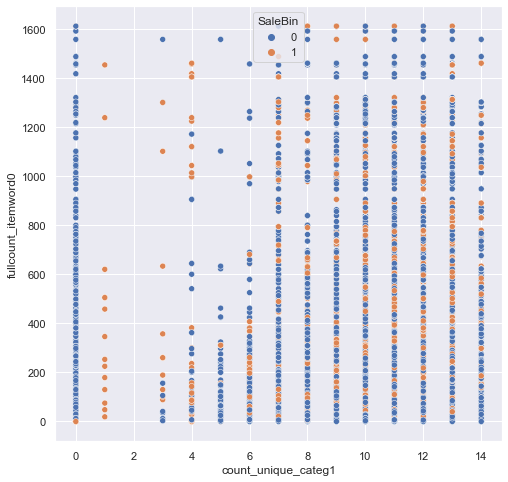

In [77]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

sns.scatterplot(ax = axs , data=tf, x='count_unique_categ1', y = 'fullcount_itemword0', hue = 'SaleBin')

In [84]:
maxDate = train_feature.Date.max()
begin = maxDate - relativedelta(months = 5)
datatrain = train_feature[train_feature.Date >= begin]

In [86]:
def reduction_sampling(data, reduction_0, sample_frac):
    df_reduce = data[data.SaleBin == 0].sample(frac = reduction_0)
    df_keep = data[data.SaleBin == 1]
    df_recons = pd.concat([df_reduce, df_keep])
    
    df_result = df_recons.sample(frac = sample_frac)
    return df_result

In [89]:
train_reduced = reduction_sampling(data = datatrain, reduction_0 = 0.60, sample_frac = 0.50)

In [123]:
train_reduced.shape

(265194, 20)

In [91]:
knn_features = ['count_unique_categ', 'count_unique_categ1', 'count_unique_categ2',
       'count_unique_shop_id', 'fullcount_categcomp', 'fullcount_itemword0']
knn_target = 'SaleBin'

In [95]:
knn_train_x = train_reduced[knn_features]
knn_train_y = train_reduced[knn_target]

In [134]:
from sklearn.neighbors import KNeighborsClassifier as knnc
from sklearn import metrics

In [143]:
my_knn = knnc(n_neighbors=6)
my_knn.fit(knn_train_x, knn_train_y)

KNeighborsClassifier(n_neighbors=6)

<b> in the validation

In [144]:
full_valandtrain_selected = val_window
full_valandtrain_selected['SaleBin'] = np.where(full_valandtrain_selected.Sale >0 , 1 ,0)
valandtrain_feature = integration_new_features_map(data = full_valandtrain_selected, dict_feature = full_features_dictionary, filter_ceros = False).fillna(0)

In [145]:
full_valandtrain_selected.shape

(383227, 24)

In [146]:
X_val = valandtrain_feature[knn_features]

In [147]:
Y_pred = my_knn.predict_proba(X_val)

In [148]:
valandtrain_feature['predSaleBin'] = Y_pred[:,1]

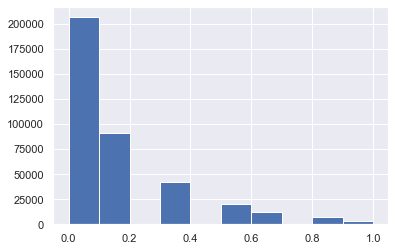

In [150]:
valandtrain_feature['predSaleBin'].hist()

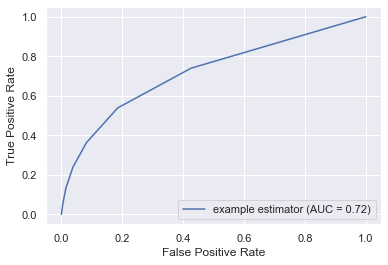

In [149]:
fpr, tpr, thresholds = metrics.roc_curve(valandtrain_feature.SaleBin, valandtrain_feature.predSaleBin)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                estimator_name='example estimator')
display.plot()

plt.show()

In [162]:
def get_knn_featrue(data):
    train_go = data.assign(SaleBin = np.where(data.Sale > 0 ,1 , 0))
    train_go = train_go[['item_id','shop_id','item_category_id','map_categ_comp1','map_categ_comp2','map_shop_comp1','map_shop_comp2',
                     'ItemWord0','ItemWord_1',
                     'Order','Date', 'SaleBin']]

    def get_full_lags_for_KNN(whole, date_to_take):

        data = whole[ whole.Date < date_to_take]
        data['itemShopMax'] = data.groupby(['shop_id','item_id']).SaleBin.transform('max')
        data['possnumb'] = np.where(data.SaleBin > 0 , 1,0)
        data['possCounts'] = data.groupby(['item_id','shop_id']).possnumb.transform('sum')

        features_dictionary = dict()
        #########################################
        ### only item Columns  ##################
        ########################################

        date_max = data.Date.max()
        date_max = datetime.datetime(date_max.year, date_max.month, date_max.day)

        data['OrderGot'] = data.groupby(['item_id']).Order.transform('min')
        data['SpaceOrder'] = data['Order'] - data['OrderGot']

        #########################################
        ### starts  ##################
        ########################################

        starts = data.groupby('item_id').agg(OrderGot = ('OrderGot','max')).reset_index()

        features_dictionary['Starts'] = {'data':starts, 'keys':['item_id']}


        ####################### ####
        ####### counting ##########
        ############################

        def counting_go(data,variable, column, variable_name, time_feature = 'Date'):
            data_to_use = data
            data_to_use = data_to_use[data_to_use.SaleBin >= 1]
            df_feature = data_to_use.groupby([variable] + [time_feature]).agg(countx = (column,'nunique')).reset_index()
            df_feature = df_feature.rename(columns = {'countx': f'count_unique_{variable_name}'})
            if time_feature == 'Date':
                df_feature[time_feature] = df_feature[time_feature] + pd.DateOffset(months=1)
            else:
                df_feature[time_feature] = df_feature[time_feature] + 1
            del data_to_use
            return  {'data': df_feature, 'keys':[variable,  time_feature]}

        features_dictionary['count shop in item'] = counting_go(data = data,variable = 'shop_id', column = 'item_id', variable_name = 'item')
        features_dictionary['count shop in item'] = counting_go(data = data,variable = 'shop_id', column = 'item_category_id', variable_name = 'categ')
        features_dictionary['count shop in categ1'] = counting_go(data = data,variable = 'shop_id', column = 'map_categ_comp1', variable_name = 'categ1')
        features_dictionary['count shop in categ1'] = counting_go(data = data,variable = 'map_shop_comp2', column = 'map_categ_comp1', variable_name = 'categ1')
        features_dictionary['count shop in categ2'] = counting_go(data = data,variable = 'shop_id', column = 'map_categ_comp2', variable_name = 'categ2')
        features_dictionary['count item in shop'] = counting_go(data = data,variable = 'item_id', column = 'shop_id', variable_name = 'shop_id')

        def counting_total(data, variables,  variable_name, rolling):
            data_to_use = data
            data_to_use = data_to_use[data_to_use.SaleBin >= 1]
            maxDate = data_to_use.Date.max()
            #beginDate = maxDate - relativedelta(months = 12)
            #data_to_use = data_to_use[data_to_use.Date > beginDate]
            df_feature = data_to_use.groupby(variables + ['Date']).agg(countx = ('SaleBin','sum')).reset_index()
            df_feature['rolling_feature'] = df_feature.sort_values('Date').groupby(variables)['countx'].rolling(rolling, min_periods=1).sum().reset_index(level=0, drop=True)
            df_feature['Date'] = df_feature['Date'] + pd.DateOffset(months=1)
            df_feature = df_feature.rename(columns = { 'rolling_feature': f'fullcount_{variable_name}'}).drop(columns = ['countx'])

            return  {'data': df_feature, 'keys':variables + ['Date']}

        features_dictionary['count catego global'] = counting_total(data = data, variables = ['map_categ_comp1'],  variable_name = 'categcomp', rolling = 3)
        features_dictionary['count itemword global'] = counting_total(data = data, variables = ['ItemWord0'],  variable_name = 'itemword0', rolling = 3)

        return features_dictionary

    def integration_new_features_map(data, dict_feature, filter_ceros = True):
        data_wow = data

        ## first merge
        data_wow = data_wow.merge(dict_feature['Starts']['data'], on = dict_feature['Starts']['keys'], how = 'left')

        ### further features
        data_wow['SpaceOrder'] = data_wow['Order'] - data_wow['OrderGot']
        data_wow['SpaceOrder'] = data_wow['SpaceOrder'].fillna(0)

        ## second merge

        for keyx in list(dict_feature.keys())[1:]:
            data_left = dict_feature[keyx]['data']
            onx = dict_feature[keyx]['keys']
            data_wow = data_wow.merge(data_left, on = onx, how = 'left')


        return data_wow.fillna(0)
    
    features_dictionary = get_full_lags_for_KNN(whole = train_go, date_to_take = date_val) ## for train but result easy in val
    full_features_dictionary = {**features_dictionary}
    train_feature = integration_new_features_map(data = train_go, dict_feature = full_features_dictionary)
    
    maxDate = train_feature.Date.max()
    begin = maxDate - relativedelta(months = 5)
    datatrain = train_feature[train_feature.Date >= begin]
    
    def reduction_sampling(data, reduction_0, sample_frac):
        df_reduce = data[data.SaleBin == 0].sample(frac = reduction_0)
        df_keep = data[data.SaleBin == 1]
        df_recons = pd.concat([df_reduce, df_keep])

        df_result = df_recons.sample(frac = sample_frac)
        return df_result

    train_reduced = reduction_sampling(data = datatrain, reduction_0 = 0.60, sample_frac = 0.40)
    
    knn_features = ['count_unique_categ', 'count_unique_categ1', 'count_unique_categ2',
       'count_unique_shop_id', 'fullcount_categcomp', 'fullcount_itemword0']
    knn_target = 'SaleBin'
    
    knn_train_x = train_reduced[knn_features]
    knn_train_y = train_reduced[knn_target]
    
    my_knn = knnc(n_neighbors=6)
    my_knn.fit(knn_train_x, knn_train_y)
    
    result = my_knn.predict_proba(train_feature[knn_features])[:,1]

    return result, my_knn, full_features_dictionary, knn_features 

In [163]:
preds, knn, featuredict_knn, knn_features  = get_knn_featrue(data = train_full)

In [158]:
preds.shape

(2098106,)

In [159]:
train_full.shape

(2098106, 23)

In [160]:
knn

KNeighborsClassifier(n_neighbors=6)

In [161]:
def knn_in_validation(data, machine, feature_dict, knn_features):
    full_valandtrain_selected = data
    full_valandtrain_selected['SaleBin'] = np.where(full_valandtrain_selected.Sale >0 , 1 ,0)
    valandtrain_feature = integration_new_features_map(data = full_valandtrain_selected, dict_feature = feature_dict, filter_ceros = False).fillna(0)
    
    X_val = valandtrain_feature[knn_features]
    
    Y_pred = machine.predict_proba(X_val)[:,1]
    return Y_pred

In [164]:
val_preds = knn_in_validation(data = val_window, machine = knn, feature_dict = featuredict_knn, knn_features = knn_features)

In [165]:
val_preds.shape

(383227,)

In [170]:
val_preds

array([0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [166]:
val_window.shape

(383227, 24)